# **DISTIL Usage Example: Twitter**

Here, we show how to use DISTIL to perform active learning on sentiment analysis tasks using a BERT model with a Twitter Sentiment dataset. This notebook can be easily executed on Google Colab.

## Installation and Imports

In [ ]:
!pip install pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Get DISTIL and submodlib
!git clone https://github.com/decile-team/distil.git

# REPLACE WHEN FINISHED TESTING
!cd distil && git checkout nlp_tutorials

# Required installations
!pip install -r distil/requirements/requirements.txt
!pip install transformers
!pip install datasets

# Standard imports
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import string
import unicodedata
import math

# Imports for datasets
from datasets import load_dataset, load_metric, concatenate_datasets
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset, ConcatDataset
from collections import Counter
from tqdm.auto import tqdm

# Imports for active learning
sys.path.append('distil/')
from distil.active_learning_strategies import BADGE, EntropySampling, LeastConfidenceSampling, MarginSampling, RandomSampling   # All active learning strategies showcased in this example
from distil.utils.utils import LabeledToUnlabeledDataset                        # A utility wrapper class that removes labels from labeled PyTorch dataset objects

fatal: destination path 'distil' already exists and is not an empty directory.
Already on 'nlp_tutorials'
Your branch is up to date with 'origin/nlp_tutorials'.
Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Preparing tweet_eval

tweet_eval is a dataset from Hugging Face that is used for sentiment analysis/sentiment classification. The dataset consists of 59899 English tweets from Twitter users and is split into 3 splits for training (45615), validation (2000), and testing (12284). The labels are as follows: 0 = negative, 1 = neutral, 2 = positive. The dataset can be found here: https://huggingface.co/datasets/tweet_eval

Here we preprocess the poem verses by making all words lowercase, removing punctuation, converting to ASCII format, and removing stopwards. Stopwords are commonly used words in the English language that usually do not provide any useful information for sentiment classification.

In [ ]:
# Converts all text to lowercase
def to_lower(ex):
    ex['text'] = ex['text'].lower()
    return ex

# Removes punctuation from the text
def remove_punc(ex):
    ex['text'] = ''.join(x for x in ex['text'] if x not in string.punctuation)
    return ex

# Converts text to ASCII (also converts accented text to normal)
def to_ascii(ex):
    ex['text'] = ''.join(x for x in unicodedata.normalize('NFD',ex['text']) if unicodedata.category(x) != 'Mn')
    return ex

# List of stopwords (commonly used words in English)
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

# Removes stopwords
def remove_stopwords(ex):
    ex['text'] = ' '.join(x for x in ex['text'].split() if x not in stopwords)
    return ex

# Process the data by making all text lowercase, removing puncuation, converting to ascii, and removing stopwords
def process_data(data):
    data1 = data.map(remove_punc)
    data2 = data1.map(to_ascii)
    data3 = data2.map(to_lower)
    data4 = data3.map(remove_stopwords)
    return data1

# 0 = negative, 1 = positive, 2 = no impact, 3 = mixed (both positive and negative)
train_data = load_dataset('tweet_eval', 'sentiment', split='train')
test_data = load_dataset('tweet_eval', 'sentiment', split='test')

# resulting data splits after processing the data
training_data = process_data(train_data)
testing_data = process_data(test_data)

## Tokenization and Pre-Active Learning

Here we tokenize the poem verses using the transformers' library AutoTokenizer with the bert-base-uncased configuration. We then make sure that the datasets are of the torch format, separate the training dataset into an initial training subset and remaining unlabeled subset, and define the number of active learning rounds, the budget, and the number of classes.

In [ ]:
from transformers import AutoTokenizer, get_scheduler, BertConfig, AdamW, BertModel

configuration = BertConfig()
setattr(configuration, 'l1', 512)
setattr(configuration, 'num_classes', 3)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_func(ex):
    return tokenizer(ex['text'], padding='max_length', truncation=True)

# Removes unnecessary columns and renames columns to match the model specification
train1 = training_data.map(tokenize_func)
test1 = testing_data.map(tokenize_func)
train2 = train1.remove_columns("text")
test2 = test1.remove_columns("text")
training_dataset = train2.rename_column("label", "labels")
testing_dataset = test2.rename_column("label", "labels")

training_dataset.set_format("torch")
testing_dataset.set_format("torch")

# Define the number of active learning rounds to conduct, the budget, and the number of classes in twitter dataset
nclasses = 3
n_rounds = 3
budget = 300

train_size_pc     = 200
test_size_pc      = 1000
unlabeled_size_pc = 5000

# Ensure reproducibility
np.random.seed(42)

# Generate random index lists for subset creation
full_train_subset = []
full_unlabeled_subset = []
full_test_subset = []

for class_num in range(nclasses):
    train_idx_pool = []
    for train_idx in range(len(training_dataset)):
        if training_dataset[train_idx]["labels"].item() == class_num:
            train_idx_pool.append(train_idx)
    test_idx_pool = []
    for test_idx in range(len(testing_dataset)):
        if testing_dataset[test_idx]["labels"].item() == class_num:
            test_idx_pool.append(test_idx)

    # Get a random subset from each pool
    train_idx_subset = np.random.choice(train_idx_pool, size=train_size_pc, replace = False).tolist()
    remaining_idx = list(set(train_idx_pool) - set(train_idx_subset))
    unlabeled_idx_subset = np.random.choice(remaining_idx, size=unlabeled_size_pc, replace = False).tolist()
    test_idx_subset = np.random.choice(test_idx_pool, size=test_size_pc, replace = False).tolist()
    full_train_subset.extend(train_idx_subset)
    full_unlabeled_subset.extend(unlabeled_idx_subset)
    full_test_subset.extend(test_idx_subset)

tweet_train = Subset(training_dataset, full_train_subset)
tweet_unlabeled = Subset(training_dataset, full_unlabeled_subset)
testing_dataset = Subset(testing_dataset, full_test_subset)

label_count = {0:0,1:0,2:0}
for i in range(len(tweet_train)):
    the_label = tweet_train[i]["labels"].item()
    label_count[the_label] += 1
print(label_count)

label_count = {0:0,1:0,2:0}
for i in range(len(testing_dataset)):
    the_label = testing_dataset[i]["labels"].item()
    label_count[the_label] += 1
print(label_count)

{0: 200, 1: 200, 2: 200}
{0: 1000, 1: 1000, 2: 1000}


## Preparing the Model

The model here is an CustomBERTModel based on https://arxiv.org/abs/1810.04805. It uses a bidirectional tranformer scheme that pretrains based on masked language modeling and next sentence prediction. The model we use is derivated from HuggingFace's transformers library's Bert Model that can be found here: https://huggingface.co/docs/transformers/model_doc/bert.

In [ ]:
from transformers import BertModel

class CustomBERTModel(nn.Module):
    def __init__(self, config):
        super(CustomBERTModel, self).__init__()
        self.config = config
        self.bert = BertModel.from_pretrained("prajjwal1/bert-small")
        classifier_dropout = (config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob)
        self.dropout = nn.Dropout(classifier_dropout)
        self.linear1 = nn.Linear(512,config.num_classes)
        
    def get_embedding_dim(self):
        return 512

    def forward(self, input_ids=None,
               attention_mask=None,
               token_type_ids=None,
               position_ids=None,
               head_mask=None,
               inputs_embeds=None,
               labels=None,
               output_attentions=None,
               output_hidden_states=None,
               return_dict=None, freeze=False, last=False):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        if freeze:
            with torch.no_grad():
                outputs = self.bert(input_ids,
                                    attention_mask=attention_mask,
                                    token_type_ids=token_type_ids,
                                    position_ids=position_ids,
                                    head_mask=head_mask,
                                    inputs_embeds=inputs_embeds,
                                    output_attentions=output_attentions,
                                    output_hidden_states=output_hidden_states,
                                    return_dict=return_dict)
                pooled_output = self.dropout(outputs["pooler_output"])
        else:
            outputs = self.bert(input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                                position_ids=position_ids,
                                head_mask=head_mask,
                                inputs_embeds=inputs_embeds,
                                output_attentions=output_attentions,
                                output_hidden_states=output_hidden_states,
                                return_dict=return_dict)
            pooled_output = self.dropout(outputs["pooler_output"])
        linear1_output = self.linear1(pooled_output)
        if last:
            return linear1_output, pooled_output
        else:
            return linear1_output

base_dir = "models"
os.makedirs(base_dir, exist_ok = True)
model_directory = os.path.join(base_dir, 'base_model.pth')

model = CustomBERTModel(configuration)
if(torch.cuda.is_available()):
    device = "cuda"
else:
    device = "cpu"
model.to(device)

Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CustomBERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=Tr

## data_train Class

Here we define a data_train class modeled after the data_train class already included in distil/distil/active_learning_stratgies. However, the following data_train class is designed to work with the CustomBERTModel.

In [ ]:
#custom training
class data_train:
    
    def __init__(self, training_dataset, net, args):

        self.training_dataset = training_dataset
        self.net = net
        self.args = args
        
        self.n_pool = len(training_dataset)
        
        if 'islogs' not in args:
            self.args['islogs'] = False

        if 'optimizer' not in args:
            self.args['optimizer'] = 'adam'
        
        if 'isverbose' not in args:
            self.args['isverbose'] = False
        
        if 'isreset' not in args:
            self.args['isreset'] = True

        if 'n_epoch' not in args:
            self.args['n_epoch'] = 200
            
        if 'criterion' not in args:
            self.args['criterion'] = nn.CrossEntropyLoss()
            
        if 'device' not in args:
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
        else:
            self.device = args['device']

    def update_index(self, idxs_lb):
        self.idxs_lb = idxs_lb

    def update_data(self, new_training_dataset):
        """
        Updates the training dataset with the provided new training dataset
        
        Parameters
        ----------
        new_training_dataset: torch.utils.data.Dataset
            The new training dataset
        """
        self.training_dataset = new_training_dataset

    def get_acc_on_set(self, test_dataset):
        
        """
        Calculates and returns the accuracy on the given dataset to test
        
        Parameters
        ----------
        test_dataset: torch.utils.data.Dataset
            The dataset to test
        Returns
        -------
        accFinal: float
            The fraction of data points whose predictions by the current model match their targets
        """	
        
        try:
            self.clf
        except:
            self.clf = self.net

        if test_dataset is None:
            raise ValueError("Test data not present")
        
        if 'batch_size' in self.args:
            batch_size = self.args['batch_size']
        else:
            batch_size = 1 
 
        loader_te = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
        self.clf.eval()
        accFinal = 0.

        self.clf = self.clf.to(device=self.device)
        for batch in loader_te:  
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
              out = self.clf(**batch)
              accFinal += torch.sum(1.0*(torch.max(out,1)[1] == batch['labels'].view(-1))).item()

        return accFinal / len(test_dataset)

    def _train(self, epoch, loader_tr, optimizer):
        self.clf.train()
        accFinal = 0.
        criterion = self.args['criterion']
        criterion.reduction = "mean"

        for batch in loader_tr:
            batch = {k: v.to(device) for k, v in batch.items()}
            out = self.clf(**batch, freeze=True)
            loss = criterion(out, batch['labels'].view(-1))
            accFinal += torch.sum((torch.max(out,1)[1] == batch['labels'].view(-1)).float()).item()
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            # clamp gradients, just in case
            # for p in filter(lambda p: p.grad is not None, self.clf.parameters()): p.grad.data.clamp_(min=-.1, max=.1)

        return accFinal / len(loader_tr.dataset), loss

    def train(self, gradient_weights=None):

        print('Training..')
        train_logs = []
        
        try:
            self.clf
        except:
            self.clf = self.net
        
        if self.args['isreset']:
            self.clf.linear1.reset_parameters()
        
        if 'batch_size' in self.args:
            batch_size = self.args['batch_size']
        else:
            batch_size = 1

        loader_tr = DataLoader(self.training_dataset, shuffle=True, batch_size=batch_size)
        epoch = 1
        accCurrent = 0

        if self.args['optimizer'] == 'adam':
            optimizer = AdamW(self.clf.parameters(), lr = self.args['lr'])

        while epoch < self.args['n_epoch']: 
            
            accCurrent, lossCurrent = self._train(epoch, loader_tr, optimizer)
            
            epoch += 1
            if epoch % 5 == 0:
                print(str(epoch) + ' training accuracy: ' + str(accCurrent), flush=True)

            log_string = 'Epoch:' + str(epoch) + '- training accuracy:'+str(accCurrent)+'- training loss:'+str(lossCurrent)
            train_logs.append(log_string)

        print('Epoch:', str(epoch), 'Training accuracy:', round(accCurrent, 3), flush=True)

        if self.args['islogs']:
            return self.clf, train_logs
        else:
            return self.clf

## Training an Initial Model

Here we train an initial model with the number of epochs as 15, the learning rate as 5e-4, the batch size of 5, max accuracy of 0.99 and the adam optimizer.

In [ ]:
args = {'lr':1e-4, 'batch_size':5, 'n_epoch': 200, 'optimizer':'adam'} 
dt = data_train(tweet_train, model, args)
clf = dt.train()
torch.save(clf.state_dict(), model_directory)

model = CustomBERTModel(configuration)
state_dict = torch.load(model_directory)
model.load_state_dict(state_dict)

Training..


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


5 training accuracy: 0.475
10 training accuracy: 0.5166666666666667
15 training accuracy: 0.5516666666666666
20 training accuracy: 0.585
25 training accuracy: 0.5933333333333334
30 training accuracy: 0.5766666666666667
35 training accuracy: 0.595
40 training accuracy: 0.595
45 training accuracy: 0.6066666666666667
50 training accuracy: 0.5933333333333334
55 training accuracy: 0.585
60 training accuracy: 0.6216666666666667
65 training accuracy: 0.6033333333333334
70 training accuracy: 0.6166666666666667
75 training accuracy: 0.615
80 training accuracy: 0.6216666666666667
85 training accuracy: 0.6233333333333333
90 training accuracy: 0.645
95 training accuracy: 0.645
100 training accuracy: 0.6283333333333333
105 training accuracy: 0.6483333333333333
110 training accuracy: 0.6166666666666667
115 training accuracy: 0.6216666666666667
120 training accuracy: 0.6216666666666667
125 training accuracy: 0.6433333333333333
130 training accuracy: 0.6466666666666666
135 training accuracy: 0.6316666

## Active Learning Strategies

Here, we show some active learning strategies being used for sentiment analysis with the poem_sentiment dataset.

### Random Sampling
This strategy is often used as a baseline, where we pick a subset of unlabeled points randomly. Here we create a instance of distil.active_learning_strategies.random_sampling.RandomSampling by passing following parameters:

**training_dataset** – The labeled dataset

**unlabeled_dataset** – The unlabeled dataset, which has a wrapper around it that strips the label

**net (class object)** – Model architecture used for training. Could be instance of models defined in distil.utils.models or something similar.

**nclasses (int)** – No. of classes in tha dataset

**args (dictionary)**– This dictionary should have ‘batch_size’ as a key. 'batch_size' should be such that one can exploit the benefits of tensorization while honouring the resourse constraits. This ‘batch_size’ therefore can be different than the one used for training.


In [ ]:
strategy_args = {'batch_size' : 5}
strategy = RandomSampling(tweet_train, tweet_unlabeled, model, nclasses, strategy_args)

# Update the model used in the AL strategy with the loaded initial model
strategy.update_model(model)

# Get the test accuracy of the initial model
acc = np.zeros(n_rounds)
acc[0] = dt.get_acc_on_set(testing_dataset)
print('Initial Testing accuracy:', round(acc[0]*100, 2), flush=True)

# User Controlled Loop
for rd in range(1, n_rounds):
    print('-------------------------------------------------')
    print('Round', rd) 
    print('-------------------------------------------------')

    # Use select() to obtain the indices in the unlabeled set that should be labeled
    idx = strategy.select(budget)

    # Add the selected points to the train set. The unlabeled set shown in the next couple lines 
    # already has the associated labels, so no human labeling is needed. Again, this is because 
    # we already have the labels a priori. In real scenarios, a human oracle would need to provide 
    # then before proceeding.
    tweet_train = ConcatDataset([tweet_train, Subset(tweet_unlabeled, idx)])
    remaining_unlabeled_idx = list(set(range(len(tweet_unlabeled))) - set(idx))
    tweet_unlabeled = Subset(tweet_unlabeled, remaining_unlabeled_idx)

    print('Number of training points -', len(tweet_train))

    # Update the data used in the AL strategy and the training class
    strategy.update_data(tweet_train, tweet_unlabeled)
    dt.update_data(tweet_train)

    # Retrain the model and update the strategy with the result
    clf = dt.train()
    strategy.update_model(clf)

    # Get new test accuracy
    acc[rd] = dt.get_acc_on_set(testing_dataset)
    print('Testing accuracy:', round(acc[rd]*100, 2), flush=True)

print('Training Completed')

#Saving accuracies for further analysis
with open(os.path.join(base_dir,'random.txt'), 'w') as f:
    for item in acc:
        f.write("%s\n" % item)

Initial Testing accuracy: 57.83
-------------------------------------------------
Round 1
-------------------------------------------------
Number of training points - 900
Training..
5 training accuracy: 0.48
10 training accuracy: 0.5355555555555556
15 training accuracy: 0.56
20 training accuracy: 0.5855555555555556
25 training accuracy: 0.58
30 training accuracy: 0.5722222222222222
35 training accuracy: 0.6088888888888889
40 training accuracy: 0.5733333333333334
45 training accuracy: 0.6
50 training accuracy: 0.5966666666666667
55 training accuracy: 0.5877777777777777
60 training accuracy: 0.6266666666666667
65 training accuracy: 0.6277777777777778
70 training accuracy: 0.6344444444444445
75 training accuracy: 0.6066666666666667
80 training accuracy: 0.6033333333333334
85 training accuracy: 0.64
90 training accuracy: 0.6033333333333334
95 training accuracy: 0.6366666666666667
100 training accuracy: 0.6211111111111111
105 training accuracy: 0.6144444444444445
110 training accuracy: 0.6

### Reload Data

Here we reload, reprocess, and retokenize the data and prepare for a different active learning strategy.

In [ ]:
# Converts all text to lowercase
def to_lower(ex):
    ex['text'] = ex['text'].lower()
    return ex

# Removes punctuation from the text
def remove_punc(ex):
    ex['text'] = ''.join(x for x in ex['text'] if x not in string.punctuation)
    return ex

# Converts text to ASCII (also converts accented text to normal)
def to_ascii(ex):
    ex['text'] = ''.join(x for x in unicodedata.normalize('NFD',ex['text']) if unicodedata.category(x) != 'Mn')
    return ex

# List of stopwords (commonly used words in English)
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

# Removes stopwords
def remove_stopwords(ex):
    ex['text'] = ' '.join(x for x in ex['text'].split() if x not in stopwords)
    return ex

# Process the data by making all text lowercase, removing puncuation, converting to ascii, and removing stopwords
def process_data(data):
    data1 = data.map(remove_punc)
    data2 = data1.map(to_ascii)
    data3 = data2.map(to_lower)
    data4 = data3.map(remove_stopwords)
    return data1

# 0 = negative, 1 = positive, 2 = no impact, 3 = mixed (both positive and negative)
train_data = load_dataset('tweet_eval', 'sentiment', split='train')
test_data = load_dataset('tweet_eval', 'sentiment', split='test')

# resulting data splits after processing the data
training_data = process_data(train_data)
testing_data = process_data(test_data)

from transformers import AutoTokenizer, get_scheduler, BertConfig, AdamW, BertModel

configuration = BertConfig()
setattr(configuration, 'l1', 512)
setattr(configuration, 'num_classes', 3)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_func(ex):
    return tokenizer(ex['text'], padding='max_length', truncation=True)

# Removes unnecessary columns and renames columns to match the model specification
train1 = training_data.map(tokenize_func)
test1 = testing_data.map(tokenize_func)
train2 = train1.remove_columns("text")
test2 = test1.remove_columns("text")
training_dataset = train2.rename_column("label", "labels")
testing_dataset = test2.rename_column("label", "labels")

training_dataset.set_format("torch")
testing_dataset.set_format("torch")

# Define the number of active learning rounds to conduct, the budget, and the number of classes in twitter dataset
nclasses = 3
n_rounds = 3
budget = 300

train_size_pc     = 200
test_size_pc      = 1000
unlabeled_size_pc = 5000

# Ensure reproducibility
np.random.seed(42)

# Generate random index lists for subset creation
full_train_subset = []
full_unlabeled_subset = []
full_test_subset = []

for class_num in range(nclasses):
    train_idx_pool = []
    for train_idx in range(len(training_dataset)):
        if training_dataset[train_idx]["labels"].item() == class_num:
            train_idx_pool.append(train_idx)
    test_idx_pool = []
    for test_idx in range(len(testing_dataset)):
        if testing_dataset[test_idx]["labels"].item() == class_num:
            test_idx_pool.append(test_idx)

    # Get a random subset from each pool
    train_idx_subset = np.random.choice(train_idx_pool, size=train_size_pc, replace = False).tolist()
    remaining_idx = list(set(train_idx_pool) - set(train_idx_subset))
    unlabeled_idx_subset = np.random.choice(remaining_idx, size=unlabeled_size_pc, replace = False).tolist()
    test_idx_subset = np.random.choice(test_idx_pool, size=test_size_pc, replace = False).tolist()
    full_train_subset.extend(train_idx_subset)
    full_unlabeled_subset.extend(unlabeled_idx_subset)
    full_test_subset.extend(test_idx_subset)

tweet_train = Subset(training_dataset, full_train_subset)
tweet_unlabeled = Subset(training_dataset, full_unlabeled_subset)
testing_dataset = Subset(testing_dataset, full_test_subset)

model = CustomBERTModel(configuration)
state_dict = torch.load(model_directory)
model.load_state_dict(state_dict)

  0%|          | 0/12284 [00:00<?, ?ex/s]

Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

### Entropy Sampling
A very basic strategy to select unlabeled points is entropy sampling, where we select samples about which the model is most uncertain by measuring the entropy of the class prediction. Hence, a valid strategy is to select those points in the unlabeled set with highest entropy (maximum uncertainty). Specifically, let $z_i$ be output from the model. By applying a softmax, we obtain probabilities that we can use: $$\sigma(z)_i = \frac{e^{z_i}}{\sum_j e^{z_j}}$$ Then, the entropy can be calculated as $$ENTROPY = -\sum_j \sigma(z)_j*log(\sigma(z)_j)$$

Here we create a instance of distil.active_learning_strategies.entropy_sampling.EntropySampling with the same parameters passed to distil.active_learning_strategies.random_sampling.RandomSampling.

In [ ]:
strategy_args = {'batch_size' : 5}
strategy = EntropySampling(tweet_train, tweet_unlabeled, model, nclasses, strategy_args)

# Use the same training parameters as before
args = {'lr':1e-4, 'batch_size':5, 'n_epoch': 200, 'optimizer':'adam'} 
dt = data_train(tweet_train, model, args)

# Update the model used in the AL strategy with the loaded initial model
strategy.update_model(model)

# Get the test accuracy of the initial model
acc = np.zeros(n_rounds)
acc[0] = dt.get_acc_on_set(testing_dataset)
print('Initial Testing accuracy:', round(acc[0]*100, 2), flush=True)

# User Controlled Loop
for rd in range(1, n_rounds):
    print('-------------------------------------------------')
    print('Round', rd) 
    print('-------------------------------------------------')

    # Use select() to obtain the indices in the unlabeled set that should be labeled
    idx = strategy.select(budget)

    # Add the selected points to the train set. The unlabeled set shown in the next couple lines 
    # already has the associated labels, so no human labeling is needed. Again, this is because 
    # we already have the labels a priori. In real scenarios, a human oracle would need to provide 
    # then before proceeding.
    tweet_train = ConcatDataset([tweet_train, Subset(tweet_unlabeled, idx)])
    remaining_unlabeled_idx = list(set(range(len(tweet_unlabeled))) - set(idx))
    tweet_unlabeled = Subset(tweet_unlabeled, remaining_unlabeled_idx)

    print('Number of training points -', len(tweet_train))

    # Update the data used in the AL strategy and the training class
    strategy.update_data(tweet_train, tweet_unlabeled)
    dt.update_data(tweet_train)

    # Retrain the model and update the strategy with the result
    clf = dt.train()
    strategy.update_model(clf)

    # Get new test accuracy
    acc[rd] = dt.get_acc_on_set(testing_dataset)
    print('Testing accuracy:', round(acc[rd]*100, 2), flush=True)

print('Training Completed')

#Saving accuracies for further analysis
with open(os.path.join(base_dir,'entropy.txt'), 'w') as f:
    for item in acc:
        f.write("%s\n" % item)

Initial Testing accuracy: 57.83
-------------------------------------------------
Round 1
-------------------------------------------------
Number of training points - 900
Training..
5 training accuracy: 0.4822222222222222
10 training accuracy: 0.5222222222222223
15 training accuracy: 0.5677777777777778
20 training accuracy: 0.5444444444444444
25 training accuracy: 0.57
30 training accuracy: 0.5766666666666667
35 training accuracy: 0.5744444444444444
40 training accuracy: 0.5722222222222222
45 training accuracy: 0.5611111111111111
50 training accuracy: 0.5477777777777778
55 training accuracy: 0.5988888888888889
60 training accuracy: 0.5755555555555556
65 training accuracy: 0.59
70 training accuracy: 0.5822222222222222
75 training accuracy: 0.5933333333333334
80 training accuracy: 0.5888888888888889
85 training accuracy: 0.5988888888888889
90 training accuracy: 0.6022222222222222
95 training accuracy: 0.5988888888888889
100 training accuracy: 0.5822222222222222
105 training accuracy: 0.

### Reload Data

Here we reload, reprocess, and retokenize the data and prepare for a different active learning strategy.

In [ ]:
# Converts all text to lowercase
def to_lower(ex):
    ex['text'] = ex['text'].lower()
    return ex

# Removes punctuation from the text
def remove_punc(ex):
    ex['text'] = ''.join(x for x in ex['text'] if x not in string.punctuation)
    return ex

# Converts text to ASCII (also converts accented text to normal)
def to_ascii(ex):
    ex['text'] = ''.join(x for x in unicodedata.normalize('NFD',ex['text']) if unicodedata.category(x) != 'Mn')
    return ex

# List of stopwords (commonly used words in English)
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

# Removes stopwords
def remove_stopwords(ex):
    ex['text'] = ' '.join(x for x in ex['text'].split() if x not in stopwords)
    return ex

# Process the data by making all text lowercase, removing puncuation, converting to ascii, and removing stopwords
def process_data(data):
    data1 = data.map(remove_punc)
    data2 = data1.map(to_ascii)
    data3 = data2.map(to_lower)
    data4 = data3.map(remove_stopwords)
    return data1

# 0 = negative, 1 = positive, 2 = no impact, 3 = mixed (both positive and negative)
train_data = load_dataset('tweet_eval', 'sentiment', split='train')
test_data = load_dataset('tweet_eval', 'sentiment', split='test')

# resulting data splits after processing the data
training_data = process_data(train_data)
testing_data = process_data(test_data)

from transformers import AutoTokenizer, get_scheduler, BertConfig, AdamW, BertModel

configuration = BertConfig()
setattr(configuration, 'l1', 512)
setattr(configuration, 'num_classes', 3)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_func(ex):
    return tokenizer(ex['text'], padding='max_length', truncation=True)

# Removes unnecessary columns and renames columns to match the model specification
train1 = training_data.map(tokenize_func)
test1 = testing_data.map(tokenize_func)
train2 = train1.remove_columns("text")
test2 = test1.remove_columns("text")
training_dataset = train2.rename_column("label", "labels")
testing_dataset = test2.rename_column("label", "labels")

training_dataset.set_format("torch")
testing_dataset.set_format("torch")

# Define the number of active learning rounds to conduct, the budget, and the number of classes in twitter dataset
nclasses = 3
n_rounds = 3
budget = 300

train_size_pc     = 200
test_size_pc      = 1000
unlabeled_size_pc = 5000

# Ensure reproducibility
np.random.seed(42)

# Generate random index lists for subset creation
full_train_subset = []
full_unlabeled_subset = []
full_test_subset = []

for class_num in range(nclasses):
    train_idx_pool = []
    for train_idx in range(len(training_dataset)):
        if training_dataset[train_idx]["labels"].item() == class_num:
            train_idx_pool.append(train_idx)
    test_idx_pool = []
    for test_idx in range(len(testing_dataset)):
        if testing_dataset[test_idx]["labels"].item() == class_num:
            test_idx_pool.append(test_idx)

    # Get a random subset from each pool
    train_idx_subset = np.random.choice(train_idx_pool, size=train_size_pc, replace = False).tolist()
    remaining_idx = list(set(train_idx_pool) - set(train_idx_subset))
    unlabeled_idx_subset = np.random.choice(remaining_idx, size=unlabeled_size_pc, replace = False).tolist()
    test_idx_subset = np.random.choice(test_idx_pool, size=test_size_pc, replace = False).tolist()
    full_train_subset.extend(train_idx_subset)
    full_unlabeled_subset.extend(unlabeled_idx_subset)
    full_test_subset.extend(test_idx_subset)

tweet_train = Subset(training_dataset, full_train_subset)
tweet_unlabeled = Subset(training_dataset, full_unlabeled_subset)
testing_dataset = Subset(testing_dataset, full_test_subset)

model = CustomBERTModel(configuration)
state_dict = torch.load(model_directory)
model.load_state_dict(state_dict)

Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

### BADGE
This method is based on the paper [Deep Batch Active Learning by Diverse, Uncertain Gradient Lower Bounds](https://arxiv.org/abs/1906.03671). The strategy is meant to select points that are both diverse (e.g., their embeddings span multiple directions) and uncertain (e.g., their contribution to the loss is large). The following steps are taken:

* Calculate the pseudo-label for each point in the unlabeled set. The pseudo-label is the class with the highest probability.
* Compute the cross-entropy loss for each point in the unlabeled set using this pseudo-label.
* Obtain the resulting loss gradients on the last linear layer of the model for each point. (These are referred to as the hypothesized loss gradients.)
* Using these gradients as a form of embedding for each unlabeled point, run k-means++ initialization on this embedding set, retrieving $k$ centers. Each center is a point from the unlabeled set, and $k$ represents the active learning budget.
* Request labels for the $k$ points whose embeddings were selected.

Here we create a instance of distil.active_learning_strategies.badge.BADGE with same parameters passed to distil.active_learning_strategies.random_sampling.RandomSampling.

In [ ]:
strategy_args = {'batch_size' : 5}
strategy = BADGE(tweet_train, tweet_unlabeled, model, nclasses, strategy_args)

# Use the same training parameters as before
args = {'lr':1e-4, 'batch_size':5, 'n_epoch': 200, 'optimizer':'adam'} 
dt = data_train(tweet_train, model, args)

# Update the model used in the AL strategy with the loaded initial model
strategy.update_model(model)

# Get the test accuracy of the initial model
acc = np.zeros(n_rounds)
acc[0] = dt.get_acc_on_set(testing_dataset)
print('Initial Testing accuracy:', round(acc[0]*100, 2), flush=True)

# User Controlled Loop
for rd in range(1, n_rounds):
    print('-------------------------------------------------')
    print('Round', rd) 
    print('-------------------------------------------------')

    # Use select() to obtain the indices in the unlabeled set that should be labeled
    idx = strategy.select(budget)

    # Add the selected points to the train set. The unlabeled set shown in the next couple lines 
    # already has the associated labels, so no human labeling is needed. Again, this is because 
    # we already have the labels a priori. In real scenarios, a human oracle would need to provide 
    # then before proceeding.
    tweet_train = ConcatDataset([tweet_train, Subset(tweet_unlabeled, idx)])
    remaining_unlabeled_idx = list(set(range(len(tweet_unlabeled))) - set(idx))
    tweet_unlabeled = Subset(tweet_unlabeled, remaining_unlabeled_idx)

    print('Number of training points -', len(tweet_train))

    # Update the data used in the AL strategy and the training class
    strategy.update_data(tweet_train, tweet_unlabeled)
    dt.update_data(tweet_train)

    # Retrain the model and update the strategy with the result
    clf = dt.train()
    strategy.update_model(clf)

    # Get new test accuracy
    acc[rd] = dt.get_acc_on_set(testing_dataset)
    print('Testing accuracy:', round(acc[rd]*100, 2), flush=True)

print('Training Completed')

#Saving accuracies for further analysis
with open(os.path.join(base_dir,'badge.txt'), 'w') as f:
    for item in acc:
        f.write("%s\n" % item)

Initial Testing accuracy: 57.83
-------------------------------------------------
Round 1
-------------------------------------------------
Number of training points - 900
Training..


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


5 training accuracy: 0.4722222222222222
10 training accuracy: 0.5011111111111111
15 training accuracy: 0.5333333333333333
20 training accuracy: 0.5611111111111111
25 training accuracy: 0.5555555555555556
30 training accuracy: 0.5855555555555556
35 training accuracy: 0.5822222222222222
40 training accuracy: 0.5633333333333334
45 training accuracy: 0.5922222222222222
50 training accuracy: 0.5944444444444444
55 training accuracy: 0.5844444444444444
60 training accuracy: 0.5966666666666667
65 training accuracy: 0.5855555555555556
70 training accuracy: 0.6077777777777778
75 training accuracy: 0.6022222222222222
80 training accuracy: 0.5977777777777777
85 training accuracy: 0.6088888888888889
90 training accuracy: 0.6222222222222222
95 training accuracy: 0.6155555555555555
100 training accuracy: 0.6344444444444445
105 training accuracy: 0.5855555555555556
110 training accuracy: 0.6122222222222222
115 training accuracy: 0.6322222222222222
120 training accuracy: 0.6322222222222222
125 training

### Reload Data

Here we reload, reprocess, and retokenize the data and prepare for a different active learning strategy.

In [ ]:
# Converts all text to lowercase
def to_lower(ex):
    ex['text'] = ex['text'].lower()
    return ex

# Removes punctuation from the text
def remove_punc(ex):
    ex['text'] = ''.join(x for x in ex['text'] if x not in string.punctuation)
    return ex

# Converts text to ASCII (also converts accented text to normal)
def to_ascii(ex):
    ex['text'] = ''.join(x for x in unicodedata.normalize('NFD',ex['text']) if unicodedata.category(x) != 'Mn')
    return ex

# List of stopwords (commonly used words in English)
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

# Removes stopwords
def remove_stopwords(ex):
    ex['text'] = ' '.join(x for x in ex['text'].split() if x not in stopwords)
    return ex

# Process the data by making all text lowercase, removing puncuation, converting to ascii, and removing stopwords
def process_data(data):
    data1 = data.map(remove_punc)
    data2 = data1.map(to_ascii)
    data3 = data2.map(to_lower)
    data4 = data3.map(remove_stopwords)
    return data1

# 0 = negative, 1 = positive, 2 = no impact, 3 = mixed (both positive and negative)
train_data = load_dataset('tweet_eval', 'sentiment', split='train')
test_data = load_dataset('tweet_eval', 'sentiment', split='test')

# resulting data splits after processing the data
training_data = process_data(train_data)
testing_data = process_data(test_data)

from transformers import AutoTokenizer, get_scheduler, BertConfig, AdamW, BertModel

configuration = BertConfig()
setattr(configuration, 'l1', 512)
setattr(configuration, 'num_classes', 3)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_func(ex):
    return tokenizer(ex['text'], padding='max_length', truncation=True)

# Removes unnecessary columns and renames columns to match the model specification
train1 = training_data.map(tokenize_func)
test1 = testing_data.map(tokenize_func)
train2 = train1.remove_columns("text")
test2 = test1.remove_columns("text")
training_dataset = train2.rename_column("label", "labels")
testing_dataset = test2.rename_column("label", "labels")

training_dataset.set_format("torch")
testing_dataset.set_format("torch")

# Define the number of active learning rounds to conduct, the budget, and the number of classes in twitter dataset
nclasses = 3
n_rounds = 3
budget = 300

train_size_pc     = 200
test_size_pc      = 1000
unlabeled_size_pc = 5000

# Ensure reproducibility
np.random.seed(42)

# Generate random index lists for subset creation
full_train_subset = []
full_unlabeled_subset = []
full_test_subset = []

for class_num in range(nclasses):
    train_idx_pool = []
    for train_idx in range(len(training_dataset)):
        if training_dataset[train_idx]["labels"].item() == class_num:
            train_idx_pool.append(train_idx)
    test_idx_pool = []
    for test_idx in range(len(testing_dataset)):
        if testing_dataset[test_idx]["labels"].item() == class_num:
            test_idx_pool.append(test_idx)

    # Get a random subset from each pool
    train_idx_subset = np.random.choice(train_idx_pool, size=train_size_pc, replace = False).tolist()
    remaining_idx = list(set(train_idx_pool) - set(train_idx_subset))
    unlabeled_idx_subset = np.random.choice(remaining_idx, size=unlabeled_size_pc, replace = False).tolist()
    test_idx_subset = np.random.choice(test_idx_pool, size=test_size_pc, replace = False).tolist()
    full_train_subset.extend(train_idx_subset)
    full_unlabeled_subset.extend(unlabeled_idx_subset)
    full_test_subset.extend(test_idx_subset)

tweet_train = Subset(training_dataset, full_train_subset)
tweet_unlabeled = Subset(training_dataset, full_unlabeled_subset)
testing_dataset = Subset(testing_dataset, full_test_subset)

model = CustomBERTModel(configuration)
state_dict = torch.load(model_directory)
model.load_state_dict(state_dict)

Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

### Least Confidence Sampling

Implements the Least Confidence Sampling Strategy a active learning strategy where the algorithm selects the data points for which the model has the lowest confidence while predicting its label.
    
Suppose the model has $nclasses$ output nodes denoted by $\overrightarrow z$ and each output node is denoted by $z_j$. Thus, $j \in [1, nclasses]$. Then for a output node $z_i$ from the model, the corresponding softmax would be $$\sigma(z_i) = \frac{e^{z_i}}{\sum_j e^{z_j}}$$
        
Then the softmax can be used pick $budget$ no. of elements for which the model has the lowest confidence as follows, $$\mbox{argmin}_{{S \subseteq {\mathcal U}, |S| \leq k}}{\sum_S(\mbox{argmax}_j{(\sigma(\overrightarrow{\boldsymbol{z}}))})}$$ where $\mathcal{U}$ denotes the Data without lables i.e. $unlabeled_x$ and $k$ is the $budget$.

In [ ]:
strategy_args = {'batch_size' : 5}
strategy = LeastConfidenceSampling(tweet_train, tweet_unlabeled, model, nclasses, strategy_args)

# Use the same training parameters as before
args = {'lr':1e-4, 'batch_size':5, 'n_epoch': 200, 'optimizer':'adam'} 
dt = data_train(tweet_train, model, args)

# Update the model used in the AL strategy with the loaded initial model
strategy.update_model(model)

# Get the test accuracy of the initial model
acc = np.zeros(n_rounds)
acc[0] = dt.get_acc_on_set(testing_dataset)
print('Initial Testing accuracy:', round(acc[0]*100, 2), flush=True)

# User Controlled Loop
for rd in range(1, n_rounds):
    print('-------------------------------------------------')
    print('Round', rd) 
    print('-------------------------------------------------')

    # Use select() to obtain the indices in the unlabeled set that should be labeled
    idx = strategy.select(budget)

    # Add the selected points to the train set. The unlabeled set shown in the next couple lines 
    # already has the associated labels, so no human labeling is needed. Again, this is because 
    # we already have the labels a priori. In real scenarios, a human oracle would need to provide 
    # then before proceeding.
    tweet_train = ConcatDataset([tweet_train, Subset(tweet_unlabeled, idx)])
    remaining_unlabeled_idx = list(set(range(len(tweet_unlabeled))) - set(idx))
    tweet_unlabeled = Subset(tweet_unlabeled, remaining_unlabeled_idx)

    print('Number of training points -', len(tweet_train))

    # Update the data used in the AL strategy and the training class
    strategy.update_data(tweet_train, tweet_unlabeled)
    dt.update_data(tweet_train)

    # Retrain the model and update the strategy with the result
    clf = dt.train()
    strategy.update_model(clf)

    # Get new test accuracy
    acc[rd] = dt.get_acc_on_set(testing_dataset)
    print('Testing accuracy:', round(acc[rd]*100, 2), flush=True)

print('Training Completed')

#Saving accuracies for further analysis
with open(os.path.join(base_dir,'lcf.txt'), 'w') as f:
    for item in acc:
        f.write("%s\n" % item)

Initial Testing accuracy: 57.83
-------------------------------------------------
Round 1
-------------------------------------------------
Number of training points - 900
Training..
5 training accuracy: 0.4211111111111111
10 training accuracy: 0.46
15 training accuracy: 0.5155555555555555
20 training accuracy: 0.4988888888888889
25 training accuracy: 0.52
30 training accuracy: 0.5166666666666667
35 training accuracy: 0.5511111111111111
40 training accuracy: 0.52
45 training accuracy: 0.5644444444444444
50 training accuracy: 0.55
55 training accuracy: 0.5533333333333333
60 training accuracy: 0.5755555555555556
65 training accuracy: 0.5811111111111111
70 training accuracy: 0.5644444444444444
75 training accuracy: 0.5822222222222222
80 training accuracy: 0.5755555555555556
85 training accuracy: 0.5755555555555556
90 training accuracy: 0.5833333333333334
95 training accuracy: 0.5633333333333334
100 training accuracy: 0.5877777777777777
105 training accuracy: 0.5988888888888889
110 trainin

### Reload Data

Here we reload, reprocess, and retokenize the data and prepare for a different active learning strategy.

In [ ]:
# Converts all text to lowercase
def to_lower(ex):
    ex['text'] = ex['text'].lower()
    return ex

# Removes punctuation from the text
def remove_punc(ex):
    ex['text'] = ''.join(x for x in ex['text'] if x not in string.punctuation)
    return ex

# Converts text to ASCII (also converts accented text to normal)
def to_ascii(ex):
    ex['text'] = ''.join(x for x in unicodedata.normalize('NFD',ex['text']) if unicodedata.category(x) != 'Mn')
    return ex

# List of stopwords (commonly used words in English)
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", 
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", 
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves" ]

# Removes stopwords
def remove_stopwords(ex):
    ex['text'] = ' '.join(x for x in ex['text'].split() if x not in stopwords)
    return ex

# Process the data by making all text lowercase, removing puncuation, converting to ascii, and removing stopwords
def process_data(data):
    data1 = data.map(remove_punc)
    data2 = data1.map(to_ascii)
    data3 = data2.map(to_lower)
    data4 = data3.map(remove_stopwords)
    return data1

# 0 = negative, 1 = positive, 2 = no impact, 3 = mixed (both positive and negative)
train_data = load_dataset('tweet_eval', 'sentiment', split='train')
test_data = load_dataset('tweet_eval', 'sentiment', split='test')

# resulting data splits after processing the data
training_data = process_data(train_data)
testing_data = process_data(test_data)

from transformers import AutoTokenizer, get_scheduler, BertConfig, AdamW, BertModel

configuration = BertConfig()
setattr(configuration, 'l1', 512)
setattr(configuration, 'num_classes', 3)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_func(ex):
    return tokenizer(ex['text'], padding='max_length', truncation=True)

# Removes unnecessary columns and renames columns to match the model specification
train1 = training_data.map(tokenize_func)
test1 = testing_data.map(tokenize_func)
train2 = train1.remove_columns("text")
test2 = test1.remove_columns("text")
training_dataset = train2.rename_column("label", "labels")
testing_dataset = test2.rename_column("label", "labels")

training_dataset.set_format("torch")
testing_dataset.set_format("torch")

# Define the number of active learning rounds to conduct, the budget, and the number of classes in twitter dataset
nclasses = 3
n_rounds = 3
budget = 300

train_size_pc     = 200
test_size_pc      = 1000
unlabeled_size_pc = 5000

# Ensure reproducibility
np.random.seed(42)

# Generate random index lists for subset creation
full_train_subset = []
full_unlabeled_subset = []
full_test_subset = []

for class_num in range(nclasses):
    train_idx_pool = []
    for train_idx in range(len(training_dataset)):
        if training_dataset[train_idx]["labels"].item() == class_num:
            train_idx_pool.append(train_idx)
    test_idx_pool = []
    for test_idx in range(len(testing_dataset)):
        if testing_dataset[test_idx]["labels"].item() == class_num:
            test_idx_pool.append(test_idx)

    # Get a random subset from each pool
    train_idx_subset = np.random.choice(train_idx_pool, size=train_size_pc, replace = False).tolist()
    remaining_idx = list(set(train_idx_pool) - set(train_idx_subset))
    unlabeled_idx_subset = np.random.choice(remaining_idx, size=unlabeled_size_pc, replace = False).tolist()
    test_idx_subset = np.random.choice(test_idx_pool, size=test_size_pc, replace = False).tolist()
    full_train_subset.extend(train_idx_subset)
    full_unlabeled_subset.extend(unlabeled_idx_subset)
    full_test_subset.extend(test_idx_subset)

tweet_train = Subset(training_dataset, full_train_subset)
tweet_unlabeled = Subset(training_dataset, full_unlabeled_subset)
testing_dataset = Subset(testing_dataset, full_test_subset)

model = CustomBERTModel(configuration)
state_dict = torch.load(model_directory)
model.load_state_dict(state_dict)

Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

### Margin Sampling

Implements the Margin Sampling Strategy a active learning strategy similar to Least Confidence Sampling Strategy. While least confidence only takes into consideration the maximum probability, margin sampling considers the difference between the confidence of first and the second most probable labels.  
    
Suppose the model has $nclasses$ output nodes denoted by $\overrightarrow{\boldsymbol{z}}$ and each output node is denoted by $z_j$. Thus, $j \in [1, nclasses]$. Then for a output node $z_i$ from the model, the corresponding softmax would be $$\sigma(z_i) = \frac{e^{z_i}}{\sum_j e^{z_j}} 
        
Let, $$m = \mbox{argmax}_j{(\sigma(\overrightarrow{\boldsymbol{z}}))}$$
Then using softmax, Margin Sampling Strategy would pick $budget$ no. of elements as follows, $$\mbox{argmin}_{{S \subseteq {\mathcal U}, |S| \leq k}}{\sum_S(\mbox{argmax}_j {(\sigma(\overrightarrow{\boldsymbol{z}}))}) - (\mbox{argmax}_{j \ne m} {(\sigma(\overrightarrow{\boldsymbol{z}}))})} $$ where $\mathcal{U}$ denotes the Data without lables i.e. $unlabeled_x$ and $k$ is the $budget$.

In [ ]:
strategy_args = {'batch_size' : 5}
strategy = MarginSampling(tweet_train, tweet_unlabeled, model, nclasses, strategy_args)

# Use the same training parameters as before
args = {'lr':1e-4, 'batch_size':5, 'n_epoch': 200, 'optimizer':'adam'} 
dt = data_train(tweet_train, model, args)

# Update the model used in the AL strategy with the loaded initial model
strategy.update_model(model)

# Get the test accuracy of the initial model
acc = np.zeros(n_rounds)
acc[0] = dt.get_acc_on_set(testing_dataset)
print('Initial Testing accuracy:', round(acc[0]*100, 2), flush=True)

# User Controlled Loop
for rd in range(1, n_rounds):
    print('-------------------------------------------------')
    print('Round', rd) 
    print('-------------------------------------------------')

    # Use select() to obtain the indices in the unlabeled set that should be labeled
    idx = strategy.select(budget)

    # Add the selected points to the train set. The unlabeled set shown in the next couple lines 
    # already has the associated labels, so no human labeling is needed. Again, this is because 
    # we already have the labels a priori. In real scenarios, a human oracle would need to provide 
    # then before proceeding.
    tweet_train = ConcatDataset([tweet_train, Subset(tweet_unlabeled, idx)])
    remaining_unlabeled_idx = list(set(range(len(tweet_unlabeled))) - set(idx))
    tweet_unlabeled = Subset(tweet_unlabeled, remaining_unlabeled_idx)

    print('Number of training points -', len(tweet_train))

    # Update the data used in the AL strategy and the training class
    strategy.update_data(tweet_train, tweet_unlabeled)
    dt.update_data(tweet_train)

    # Retrain the model and update the strategy with the result
    clf = dt.train()
    strategy.update_model(clf)

    # Get new test accuracy
    acc[rd] = dt.get_acc_on_set(testing_dataset)
    print('Testing accuracy:', round(acc[rd]*100, 2), flush=True)

print('Training Completed')

#Saving accuracies for further analysis
with open(os.path.join(base_dir,'margin.txt'), 'w') as f:
    for item in acc:
        f.write("%s\n" % item)

Initial Testing accuracy: 57.83
-------------------------------------------------
Round 1
-------------------------------------------------
Number of training points - 900
Training..
5 training accuracy: 0.43555555555555553
10 training accuracy: 0.4955555555555556
15 training accuracy: 0.5266666666666666
20 training accuracy: 0.5522222222222222
25 training accuracy: 0.5533333333333333
30 training accuracy: 0.5533333333333333
35 training accuracy: 0.5655555555555556
40 training accuracy: 0.5688888888888889
45 training accuracy: 0.5444444444444444
50 training accuracy: 0.5555555555555556
55 training accuracy: 0.57
60 training accuracy: 0.5855555555555556
65 training accuracy: 0.6
70 training accuracy: 0.58
75 training accuracy: 0.5988888888888889
80 training accuracy: 0.5888888888888889
85 training accuracy: 0.5866666666666667
90 training accuracy: 0.5888888888888889
95 training accuracy: 0.61
100 training accuracy: 0.5933333333333334
105 training accuracy: 0.5933333333333334
110 trainin

## Visualizing the Results

Text(0.5, 1.0, 'DISTIL_Twitter')

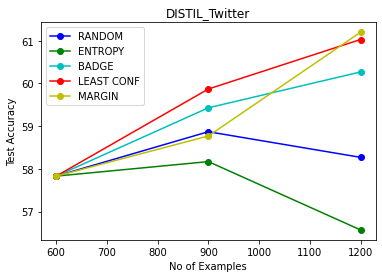

In [ ]:
# Load the accuracies previously obtained
with open(os.path.join(base_dir,'random.txt'), 'r') as f:
  acc_ = f.readlines()
acc_rd = [round(float(x)*100, 2) for x in acc_]
with open(os.path.join(base_dir,'entropy.txt'), 'r') as f:
  acc_ = f.readlines()
acc_en = [round(float(x)*100, 2) for x in acc_]
with open(os.path.join(base_dir,'badge.txt'), 'r') as f:
  acc_ = f.readlines()
acc_bd = [round(float(x)*100, 2) for x in acc_]
with open(os.path.join(base_dir,'lcf.txt'), 'r') as f:
  acc_ = f.readlines()
acc_lcf = [round(float(x)*100, 2) for x in acc_]
with open(os.path.join(base_dir,'margin.txt'), 'r') as f:
  acc_ = f.readlines()
acc_mg = [round(float(x)*100, 2) for x in acc_]

# Plot them using matplotlib
x_axis = np.array([train_size_pc*nclasses+budget*i for i in range(n_rounds)])
plt.figure()
plt.plot(x_axis, acc_rd, 'b-', label='RANDOM',marker='o')
plt.plot(x_axis, acc_en, 'g-', label='ENTROPY',marker='o')
plt.plot(x_axis, acc_bd, 'c', label='BADGE',marker='o')
plt.plot(x_axis, acc_lcf, 'r', label='LEAST CONF',marker='o')
plt.plot(x_axis, acc_mg, 'y', label='MARGIN',marker='o')

plt.legend()
plt.xlabel('No of Examples')
plt.ylabel('Test Accuracy')
plt.title('DISTIL_Twitter')